# Socratic Models for Multimodal Reasoning
## Introduction
In this notebook, we use the Socratic models approach applied to multimodal reasoning tasks, i.e, chain-of-thought (CoT) reasoning & visual question-answering (VQA)

### Imports

In [2]:

# global
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
from transformers import set_seed
import openai
from datasets import load_dataset
from dotenv import load_dotenv
load_dotenv()

# local 
sys.path.insert(0, '../')
import scripts.image_captioning as ic
from scripts.utils import get_device

# Local imports
from scripts.coco_caption_base_hp_tune import ImageCaptionerBaseline
# extensions
%load_ext autoreload
%autoreload 2

In [3]:
# Instantiate the baseline image captioner class.
image_captioner = ImageCaptionerBaseline(set_type='demo')

load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 0.0s!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Chain-of-thought reasoning

### Data
We use the [ScienceQA](https://scienceqa.github.io/) dataset.

In [4]:
# load scienceQA dataset
scienceQA_dataset = load_dataset('derek-thomas/ScienceQA', split='validation')
# filter out samples with no image
scienceQA_dataset = [sample for sample in scienceQA_dataset if sample['image'] is not None]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/ryanamaudruz/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


#### Visualize dataset samples

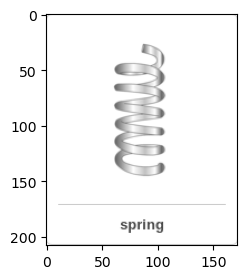

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.


In [5]:
# select & viz sample
sample_idx = 142
sample = scienceQA_dataset[sample_idx]
plt.figure(figsize=(3, 3))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

### Zero-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with a sentence to induce zero-shot CoT reasoning. Generate outputs (solution + rationale) from LM.

In [7]:
# compose prompt
prompt = image_captioner.prompt_generator.create_cot_prompt(
    sample, clip_manager, vocab_manager, place_feats, obj_feats
)
print(f'prompt: {prompt}\n')

AttributeError: 'LmPromptGenerator' object has no attribute 'create_cot_prompt'

In [ ]:
# generate output
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 1., 'n': 1}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 50, 'temperature': 1., 'do_sample': True, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)

print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {sample["answer"]}')

### Few-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with previous prompts & solutions (rational + choice) to induce few-shot CoT reasoning. Generate outputs from LM.

In [ ]:
# select & viz example & target samples
# candidate pairs: single-prop: 122, 142 | multi-prop: 340, 142, 
# sample example
eg_sample_idx, target_sample_idx = 142, 523
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(3, 3))
plt.imshow(eg_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}\nsolution: {eg_sample["solution"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(3, 3))
plt.imshow(target_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\nsolution: {target_sample["solution"]}')

In [ ]:
# generate prompt
prompt = prompt_generator.create_cot_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n' + prompt_generator.create_cot_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

In [ ]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 100, 'temperature': 1., 'do_sample': False, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt solution: {target_sample["solution"]}\ngt answer: {target_sample["answer"]}')

## Visual question-answering (VQA)
Visual question-answering using VLM (CLIP) + LM
### Zero-shot VQA

In [ ]:
# get sample
sample_idx = 148 # 134, 148
sample = scienceQA_dataset[sample_idx]
# show sample
plt.figure(figsize=(4, 3))
plt.imshow(sample['image'], aspect='auto')
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [ ]:
# compose prompt
prompt = prompt_generator.create_vqa_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

In [ ]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_tokens': 20, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 20, 'temperature': 1., 'do_sample': False} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt answer: {sample["answer"] }')

### Few-shot VQA

In [ ]:
# select & viz example & target samples
# sample example
eg_sample_idx, target_sample_idx = 148, 134
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(4, 3))
plt.imshow(eg_sample['image'], aspect='auto')
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(4, 3))
plt.imshow(target_sample['image'], aspect='auto')
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\n')

In [ ]:
# generate prompt
prompt = prompt_generator.create_vqa_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["answer"]}\n' + prompt_generator.create_vqa_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

In [1]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 100, 'temperature': 1., 'do_sample': False, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt solution: {target_sample["solution"]}\ngt answer: {target_sample["answer"]}')

NameError: name 'lm_model' is not defined

#### Set seed & device

In [2]:
set_seed(42)    # set seed for reproducibility
# set the device to use
device = get_device()
print(f'Using device: {device}')

Using device: mps


#### Class instantiation

In [3]:
# instantiate managers
clip_manager = ic.ClipManager(device=device)
image_manager = ic.ImageManager()
vocab_manager = ic.VocabManager()
prompt_generator = ic.LmPromptGenerator()

load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 0.1s!


In [4]:
# setup lm
lm_model = 'gpt' # gpt or huggingface transformer model
# OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5, EleutherAI/gpt-neox-20b
lm_manager = ic.LmManager(version=lm_model, use_api=True, device=device)
openai.api_key = os.getenv('OPENAI_API_KEY')

TypeError: __init__() got an unexpected keyword argument 'device'

#### Create image & text embeddings

In [ ]:
# compute place & objects features
place_feats = clip_manager.get_text_emb([f'Photo of a {p}.' for p in vocab_manager.place_list])
obj_feats = clip_manager.get_text_emb([f'Photo of a {o}.' for o in vocab_manager.object_list])